In [1]:
import torch
import re
import pandas as pd
from torch.nn import functional as F
from normalize_text import normalize
from transformers import AutoModel, AutoTokenizer

In [2]:
from utils import *

# 1. Load raw data

In [3]:
tokenizer = AutoTokenizer.from_pretrained('m3rg-iitd/matscibert')
model = AutoModel.from_pretrained('m3rg-iitd/matscibert')

Some weights of the model checkpoint at m3rg-iitd/matscibert were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at m3rg-iitd/matscibert and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
Y

In [4]:
max_length = 128
base_path = './abs_data/'

In [5]:
nas_csv_file = "./abs_data/TITLE-ABS-KEY ( room-temperature AND sodium-sulfur AND batteries ) AND ( DOCTYPE ( ar ) )_1.csv"
lis_csv_file = "./abs_data/TITLE-ABS-KEY (  lithium-sulfur AND electrocatalysts) AND ( DOCTYPE ( ar ) )_1.csv"
sa_csv_file = "./abs_data/TITLE-ABS-KEY ( single-atom AND electrocatalysts ) AND ( DOCTYPE ( ar ) )_1.csv"
lissa_csv_file = r"./abs_data/Li-S SA_1.csv"
irrelevant1_csv_file = r'./abs_data/Low_relevant_1.csv'
irrelevant2_csv_file = r'./abs_data/Low_relevant_2.csv'

In [6]:
nas_df, nas_list = load_csv_abstracts(nas_csv_file)
lis_df, lis_list = load_csv_abstracts(lis_csv_file)
lissa_df, lissa_list = load_csv_abstracts(lissa_csv_file)
sa_df, sa_list = load_csv_abstracts(sa_csv_file)

ir1_df, ir1_list = load_csv_abstracts(irrelevant1_csv_file)
ir2_df, ir2_list = load_csv_abstracts(irrelevant2_csv_file)

Check duplicate abstracts

In [7]:
sa_df.shape, lis_df.shape, lissa_df.shape

((1218, 4), (312, 4), (81, 4))

In [8]:
check_duplicate_df = pd.concat([sa_df, lis_df, lissa_df])
check_duplicate_df.columns, check_duplicate_df.shape

(Index(['title', 'abs', 'pub', 'doi'], dtype='object'), (1611, 4))

In [9]:
check_series = check_duplicate_df.duplicated(subset='doi', keep='last')
sa_check_series = check_series[:sa_df.shape[0]]
lis_check_series = check_series[sa_df.shape[0]:sa_df.shape[0] + lis_df.shape[0]]
lissa_check_series = check_series[-lissa_df.shape[0]:]
del check_duplicate_df

In [10]:
print(sa_check_series.value_counts())
sa_df[sa_check_series==False].shape

False    1198
True       20
dtype: int64


(1198, 4)

In [11]:
def remove_duplicate(check_series, df, abs_list):
    print(check_series.value_counts())
    new_df = df[check_series==False]
    new_list = [] 
    for check, abs in zip(check_series, abs_list):
        if check == False:
            new_list.append(abs)
    return new_df, new_list

In [12]:
sa_df, sa_list = remove_duplicate(sa_check_series, sa_df, sa_list)
lis_df, lis_list = remove_duplicate(lis_check_series, lis_df, lis_list)
lissa_df, lissa_list = remove_duplicate(lissa_check_series, lissa_df, lissa_list)

False    1198
True       20
dtype: int64
False    297
True      15
dtype: int64
False    81
dtype: int64


In [13]:
print(">>> statistical info")
print("NaS: {nas}  |  LiS:  {lis}  |  Sa:  {sa}  |  LiSSA: {lissa}".
        format(nas=len(nas_list), lis=len(lis_list), sa=len(sa_list), lissa=len(lissa_list)))
print("Irrelevant 1: {ir1}  |  Irrelevant 2: {ir2}".format(ir1=len(ir1_list), ir2=len(ir2_list)))

>>> statistical info
NaS: 202  |  LiS:  297  |  Sa:  1198  |  LiSSA: 81
Irrelevant 1: 623  |  Irrelevant 2: 1234


In [14]:
# supply more data
nssup_csv_file = r'./abs_data/ns_supply_more.csv'
npsup_csv_file = r'./abs_data/np_supply_more.csv'
othersup_csv_file = r'./abs_data/other_supply_more.csv'

nssup_df, nssup_list = load_csv_abstracts(nssup_csv_file)
npsup_df, npsup_list = load_csv_abstracts(npsup_csv_file)
othersup_df, othersup_list = load_csv_abstracts(othersup_csv_file)

# 2. Retrieve MatSciBert Embeddings

In [15]:
# if pre calculated
emb_nas_list = torch.load('./embs/nas_list.pt')
emb_sa_list = torch.load('./embs/sa_list.pt')
emb_lis_list = torch.load('./embs/lis_list.pt')
emb_lissa_list = torch.load('./embs/lissa_list.pt')
emb_ir1_list = torch.load('./embs/ir1_list.pt')
emb_ir2_list = torch.load('./embs/ir2_list.pt')

In [16]:
# remove duplicate abstracts' embeddings
def remove_duplicate_embs(check_series, emb_list):
    new_list = [] 
    for check, emb in zip(check_series, emb_list):
        if check == False:
            new_list.append(emb)
    return new_list
emb_sa_list = remove_duplicate_embs(sa_check_series, emb_sa_list)
emb_lis_list = remove_duplicate_embs(lis_check_series, emb_lis_list)

In [ ]:
# # calculate other emebeddings
# tokenized_lissa_list = [tokenize_sentences(lissa, tokenizer, max_length) for lissa in lissa_list]
# tokenized_ir1_list = [tokenize_sentences(ir, tokenizer, max_length) for ir in ir1_list]
# tokenized_ir2_list = [tokenize_sentences(ir, tokenizer, max_length) for ir in ir2_list]

In [18]:
# emb_lissa_list = [get_sum_hidden_emb(tokenized_lissa, model) for tokenized_lissa in tokenized_lissa_list]
# del tokenized_lissa_list

In [19]:
# emb_ir1_list = [get_sum_hidden_emb(tokenized_ir, model) for tokenized_ir in tokenized_ir1_list]
# del tokenized_ir1_list

In [20]:
# emb_ir2_list = [get_sum_hidden_emb(tokenized_ir, model) for tokenized_ir in tokenized_ir2_list]
# del tokenized_ir2_list

In [17]:
nas_sa_list = []
for i in range(1, 6):
    nas_sa_list.append(load_paper_to_sentences(base_path + 'nasa_{i}.txt'.format(i=i)))
tokenized_nas_sa_list = [tokenize_sentences(nasa, tokenizer, max_length) for nasa in nas_sa_list]
emb_nas_sa_list = [get_sum_hidden_emb(tokenized_nasa, model) for tokenized_nasa in tokenized_nas_sa_list]

In [22]:
# # retrieve data
# tokenized_nssup_list = [tokenize_sentences(nssup, tokenizer, max_length) for nssup in nssup_list]
# tokenized_npsup_list = [tokenize_sentences(npsup, tokenizer, max_length) for npsup in npsup_list]
# tokenized_othersup_list = [tokenize_sentences(othersup, tokenizer, max_length) for othersup in othersup_list]

In [23]:
# emb_nssup_list = [get_sum_hidden_emb(tokenized_nssup, model) for tokenized_nssup in tokenized_nssup_list]
# emb_npsup_list = [get_sum_hidden_emb(tokenized_npsup, model) for tokenized_npsup in tokenized_npsup_list]
# emb_othersup_list = [get_sum_hidden_emb(tokenized_othersup, model) for tokenized_othersup in tokenized_othersup_list]

In [24]:
# torch.save(emb_nssup_list, './embs/nssup_list.pt')
# torch.save(emb_npsup_list, './embs/npsup_list.pt')
# torch.save(emb_othersup_list, './embs/othersup_list.pt')

In [18]:
emb_nssup_list = torch.load('./embs/nssup_list.pt')
emb_npsup_list = torch.load('./embs/npsup_list.pt')
emb_othersup_list = torch.load('./embs/othersup_list.pt')

## supply more data

In [19]:
sup_title = [
    "Tuning the Coordination Structure of CuNC Single Atom Catalysts for Simultaneous Electrochemical Reduction of CO2 and NO3– to Urea",
    "Fluorine-tuned single-atom catalysts with dense surface Ni-N4 sites on ultrathin carbon nanosheets for efficient CO2 electroreduction",
    "Insights on forming N,O-coordinated Cu single-atom catalysts for electrochemical reduction CO2 to methane",
    "Coordination-tuned Fe single-atom catalyst for efficient CO2 electroreduction: The power of B atom",
    "Axial coordination regulation of MOF-based single-atom Ni catalysts by halogen atoms for enhanced CO2 electroreduction",
    "Engineering unsymmetrically coordinated Cu-S1N3 single atom sites with enhanced oxygen reduction activity",
    "Tuning the Coordination Environment in Single-Atom Catalysts to Achieve Highly Efficient Oxygen Reduction Reactions",
    "Fe Isolated Single Atoms on S, N Codoped Carbon by Copolymer Pyrolysis Strategy for Highly Efficient Oxygen Reduction Reaction"
]

sup_doi = [
    "10.1002/aenm.202201500",
    "10.1016/j.apcatb.2020.119591",
    "10.1038/s41467-020-20769-x",
    "10.1016/j.cej.2021.134270",
    "10.1007/s12274-022-4467-3",
    "10.1038/s41467-020-16848-8",
    "10.1021/jacs.9b09352",
    "10.1002/adma.201800588"
]

In [20]:
sup_abs = [
    r"Closing both the carbon and nitrogen loops is a critical venture to support the establishment of the circular, net-zero carbon economy. Although single atom catalysts (SACs) have gained interest for the electrochemical reduction reactions of both carbon dioxide (CO2RR) and nitrate (NO3RR), the structure–activity relationship for Cu SAC coordination for these reactions remains unclear and should be explored such that a fundamental understanding is developed. To this end, the role of the Cu coordination structure is investigated in dictating the activity and selectivity for the CO2RR and NO3RR. In agreement with the density functional theory calculations, it is revealed that Cu-N4 sites exhibit higher intrinsic activity toward the CO2RR, whilst both Cu-N4 and Cu-N4−x-Cx sites are active toward the NO3RR. Leveraging these findings, CO2RR and NO3RR are coupled for the formation of urea on Cu SACs, revealing the importance of *COOH binding as a critical parameter determining the catalytic activity for urea production. To the best of the authors’ knowledge, this is the first report employing SACs for electrochemical urea synthesis from CO2RR and NO3RR, which achieves a Faradaic efficiency of 28% for urea production with a current density of −27 mA cm–2 at −0.9 V versus the reversible hydrogen electrode.",
    r"A fluorine-tuned single-atom catalyst with an ultrathin nanosheet morphology (only ∼1.25 nm) and high Ni content of 5.92 wt% was fabricated by a polymer-assisted pyrolysis approach. The synthetic approach not only controls the establishment of the ultrathin nanosheet structure for achieving high surface communication, but also incorporates F dopants to manipulate the electronic structure of the metalloporphyrin-like active sites (Ni-N4). As a result, such catalyst with unique structural features exhibits a remarkable electrocatalytic performance for CO2-to-CO conversion with the Faradaic efficiency (FE) over 95 % in a wide potential range and an outstanding CO evolution rate of 1146 mmol gcat–1 h–1 at –0.97 V vs. RHE. The in situ attenuated total reflection-infrared spectroscopy (ATR-IR) and theoretical calculations further demonstrate that the F-doping modulates the electron configuration of the central Ni-N4 sites and thereby reduces the energy barrier for CO2 activation, which is favorable to the generation of the key *COOH intermediate.",
    r"Single-atom catalysts (SACs) are promising candidates to catalyze electrochemical CO2 reduction (ECR) due to maximized atomic utilization. However, products are usually limited to CO instead of hydrocarbons or oxygenates due to unfavorable high energy barrier for further electron transfer on synthesized single atom catalytic sites. Here we report a novel partial-carbonization strategy to modify the electronic structures of center atoms on SACs for lowering the overall endothermic energy of key intermediates. A carbon-dots-based SAC margined with unique CuN2O2 sites was synthesized for the first time. The introduction of oxygen ligands brings remarkably high Faradaic efficiency (78%) and selectivity (99% of ECR products) for electrochemical converting CO2 to CH4 with current density of 40 mA·cm-2 in aqueous electrolytes, surpassing most reported SACs which stop at two-electron reduction. Theoretical calculations further revealed that the high selectivity and activity on CuN2O2 active sites are due to the proper elevated CH4 and H2 energy barrier and fine-tuned electronic structure of Cu active sites.",
    r"Designing of effective electrocatalysts for electrocatalytic CO2 reduction into value-added chemicals is the key to reducing CO2 concentration and achieving carbon neutrality. However, achieving high activity and product selectivity simultaneously remains a significant challenge. Herein, a series of Fe single-atom catalysts coordinated by B atoms, namely FeBxCy (x + y = 3 or 4), are constructed to systematically investigate the electrocatalytic CO2 reduction reaction (CO2RR) based on density functional theory computations. Eight catalysts, including FeO4, are identified that can effectively activate CO2 molecules and significantly inhibit competitive hydrogen evolution reaction (HER). Among them, FeB2C and FeB2C2h (h represents a cis structure) show the higher CO2RR activity with the less negative limiting potentials of −0.24 and −0.40 V toward production of CH4, indicating the optimal content for doping B atoms. The activity mechanism shows that d-band center and magnetic moment of central Fe atom can be manipulated by rational modulating the coordinated B atoms to improve the CO2RR performance. By the coordinated B atom, an optimal adsorption strength of the reaction intermediates can be achieved on the FeBxCy surface, and thereby increasing CO2RR catalytic activity and product selectivity. FeB2C with more negative d-band center and the optimal Fe atomic magnetic moment shows the best CO2RR performance. These results reveal a great potential of coordination tuning for CO2RR, and provide a new theoretical perspective for rational design of high activity, selective CO2RR catalysts.",
    r"Single-atom catalysts (SACs), with the utmost atom utilization, have attracted extensive interests for various catalytic applications. The coordination environment of SACs has been recognized to play a vital role in catalysis while their precise regulation at atomic level remains an immense challenge. Herein, a post metal halide modification (PMHM) strategy has been developed to construct Ni-N4 sites with axially coordinated halogen atoms, named Ni1N-C (X) (X = Cl, Br, and I), on pre-synthetic nitrogen-doped carbon derived from metal-organic frameworks. The axial halogen atoms with distinct electronegativity can break the symmetric charge distribution of planar Ni-N4 sites and regulate the electronic states of central Ni atoms in Ni1N-C (X) (X = Cl, Br, and I). Significantly, the Ni1N-C (Cl) catalyst, decorated with the most electronegative Cl atoms, exhibits Faradaic efficiency of CO up to 94.7% in electrocatalytic CO2 reduction, outperforming Ni1N-C (Br) and Ni1N-C (I) catalysts. Moreover, Ni1N-C (Cl) also presents superb performance in Zn-CO2 battery with ultrahigh CO selectivity and great durability. Theoretical calculations reveal that the axially coordinated Cl atom remarkably facilitates *COOH intermediate formation on single-atom Ni sites, thereby boosting the CO2 reduction performance of Ni1N-C (Cl). This work offers a facile strategy to tailor the axial coordination environments of SACs at atomic level and manifests the crucial role of axial coordination microenvironments in catalysis.",
    r"Atomic interface regulation is thought to be an efficient method to adjust the performance of single atom catalysts. Herein, a practical strategy was reported to rationally design single copper atoms coordinated with both sulfur and nitrogen atoms in metal-organic framework derived hierarchically porous carbon (S-Cu-ISA/SNC). The atomic interface configuration of the copper site in S-Cu-ISA/SNC is detected to be an unsymmetrically arranged Cu-S1N3 moiety. The catalyst exhibits excellent oxygen reduction reaction activity with a half-wave potential of 0.918 V vs. RHE. Additionally, through in situ X-ray absorption fine structure tests, we discover that the low-valent Cuprous-S1N3 moiety acts as an active center during the oxygen reduction process. Our discovery provides a universal scheme for the controllable synthesis and performance regulation of single metal atom catalysts toward energy applications.",
    r"Designing atomically dispersed metal catalysts for oxygen reduction reaction (ORR) is a promising approach to achieve efficient energy conversion. Herein, we develop a template-assisted method to synthesize a series of single metal atoms anchored on porous N,S-codoped carbon (NSC) matrix as highly efficient ORR catalysts to investigate the correlation between the structure and their catalytic performance. The structure analysis indicates that an identical synthesis method results in distinguished structural differences between Fe-centered single-atom catalyst (Fe-SAs/NSC) and Co-centered/Ni-centered single-atom catalysts (Co-SAs/NSC and Ni-SAs/NSC) because of the different trends of each metal ion in forming a complex with the N,S-containing precursor during the initial synthesis process. The Fe-SAs/NSC mainly consists of a well-dispersed FeN4S2 center site where S atoms form bonds with the N atoms. The S atoms in Co-SAs/NSC and Ni-SAs/NSC, on the other hand, form metal–S bonds, resulting in CoN3S1 and NiN3S1 center sites. Density functional theory (DFT) reveals that the FeN4S2 center site is more active than the CoN3S1 and NiN3S1 sites, due to the higher charge density, lower energy barriers of the intermediates, and products involved. The experimental results indicate that all three single-atom catalysts could contribute high ORR electrochemical performances, while Fe-SAs/NSC exhibits the highest of all, which is even better than commercial Pt/C. Furthermore, Fe-SAs/NSC also displays high methanol tolerance as compared to commercial Pt/C and high stability up to 5000 cycles. This work provides insights into the rational design of the definitive structure of single-atom catalysts with tunable electrocatalytic activities for efficient energy conversion.",
    r"Heteroatom-doped Fe-NC catalyst has emerged as one of the most promising candidates to replace noble metal-based catalysts for highly efficient oxygen reduction reaction (ORR). However, delicate controls over their structure parameters to optimize the catalytic efficiency and molecular-level understandings of the catalytic mechanism are still challenging. Herein, a novel pyrrole–thiophene copolymer pyrolysis strategy to synthesize Fe-isolated single atoms on sulfur and nitrogen-codoped carbon (Fe-ISA/SNC) with controllable S, N doping is rationally designed. The catalytic efficiency of Fe-ISA/SNC shows a volcano-type curve with the increase of sulfur doping. The optimized Fe-ISA/SNC exhibits a half-wave potential of 0.896 V (vs reversible hydrogen electrode (RHE)), which is more positive than those of Fe-isolated single atoms on nitrogen codoped carbon (Fe-ISA/NC, 0.839 V), commercial Pt/C (0.841 V), and most reported nonprecious metal catalysts. Fe-ISA/SNC is methanol tolerable and shows negligible activity decay in alkaline condition during 15 000 voltage cycles. X-ray absorption fine structure analysis and density functional theory calculations reveal that the incorporated sulfur engineers the charges on N atoms surrounding the Fe reactive center. The enriched charge facilitates the rate-limiting reductive release of OH* and therefore improved the overall ORR efficiency."
]

In [ ]:
sup_dict = {'title': sup_title, 'abs': sup_abs, 'pub': None, 'doi': sup_doi, 'class': ['supply_more' for _ in range(len(sup_doi))]}
sup_df = pd.DataFrame(sup_dict)
sup_df.head()

In [29]:
sup_df.to_csv("./abs_data/supplied_abs.csv", index=False)

In [23]:
# sup_list = []
# for abs in sup_df['abs']:
#     sup_list.append(split_into_sentences(abs))
# tokenized_sup_list = [tokenize_sentences(sup, tokenizer, max_length) for sup in sup_list]
# emb_sup_list = [get_sum_hidden_emb(tokenized_sup, model) for tokenized_sup in tokenized_sup_list]

In [22]:
# torch.save(emb_sup_list, './embs/sup_list.pt')
emb_sup_list = torch.load('./embs/sup_list.pt')

In [25]:
# # save emb
# torch.save(emb_lissa_list, './embs/lissa_list.pt')
# torch.save(emb_ir1_list, './embs/ir1_list.pt')
# torch.save(emb_ir2_list, './embs/ir2_list.pt')

In [23]:
# release memory
del tokenizer, model

# 3. Create Labeled Dataset

In [24]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
class AbstractDataset(Dataset):
    def __init__(self, emb_nas_list, emb_lis_list, emb_sa_list, emb_lissa_list,
                       emb_ir1_list, emb_ir2_list, emb_nssup_list, emb_npsup_list, emb_othersup_list) -> None:
        # create labels
        label_nas = torch.full([len(emb_nas_list) + len(emb_nssup_list) + len(emb_npsup_list) + len(emb_othersup_list)], 0)
        label_lis = torch.full([len(emb_lis_list)], 1)
        label_sa = torch.full([len(emb_sa_list)], 2)
        label_lissa = torch.full([len(emb_lissa_list)], 3)
        label_ir1 = torch.full([len(emb_ir1_list)], 4)
        label_ir2 = torch.full([len(emb_ir2_list)], 5)
        self.labels = torch.cat([label_nas, label_lis, label_sa, label_lissa, label_ir1, label_ir2])
        # data
        emb_nas = torch.stack(emb_nas_list)
        emb_nssup = torch.stack(emb_nssup_list)
        emb_npsup = torch.stack(emb_npsup_list)
        emb_othersup = torch.stack(emb_othersup_list)
        emb_lis = torch.stack(emb_lis_list)
        emb_sa = torch.stack(emb_sa_list)
        emb_lissa = torch.stack(emb_lissa_list)
        emb_ir1 = torch.stack(emb_ir1_list)
        emb_ir2 = torch.stack(emb_ir2_list)
        self.data = torch.cat([emb_nas, emb_nssup, emb_npsup, emb_othersup, emb_lis, emb_sa, emb_lissa, emb_ir1, emb_ir2])
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, index):
        return self.data[index], self.labels[index]     

In [25]:
dataset = AbstractDataset(emb_nas_list, emb_lis_list, emb_sa_list, emb_lissa_list, emb_ir1_list, emb_ir2_list, emb_nssup_list, emb_npsup_list, emb_othersup_list)
len(dataset)

3666

In [26]:
# split train, test set
from sklearn.model_selection import train_test_split

def gen_train_test_idxs(offset, cls_idxs, test_rate=0, train_test_num={}):
    if test_rate > 0:
        train_idxs, test_idxs = train_test_split(cls_idxs, test_size=test_rate)
    else:
        train_idxs, test_idxs = train_test_split(cls_idxs, train_size = train_test_num['train'], test_size = train_test_num['test'])
    print("Train size: {tr} | Test size: {te}".format(tr=len(train_idxs), te=len(test_idxs)))
    return [idx + offset for idx in train_idxs], [idx + offset for idx in test_idxs]

In [27]:
# each class has a maximun number of 300
start_offset = 0
cut_points = []
train_idxs, val_idxs = [], []
# nas
temp_train, temp_test = gen_train_test_idxs(start_offset, list(range(len(emb_nas_list) + len(emb_nssup_list) + len(emb_npsup_list) + len(emb_othersup_list))), test_rate=0.1)
train_idxs += temp_train
val_idxs += temp_test
cut_points.append([start_offset, start_offset + len(emb_nas_list) + len(emb_nssup_list) + len(emb_npsup_list) + len(emb_othersup_list)])
start_offset += len(emb_nas_list)
# lis
temp_train, temp_test = gen_train_test_idxs(start_offset, list(range(len(emb_lis_list))), test_rate=0.1)
train_idxs += temp_train
val_idxs += temp_test
cut_points.append([start_offset, start_offset + len(emb_lis_list)])
start_offset += len(emb_lis_list)
# sa
temp_train, temp_test = gen_train_test_idxs(start_offset, list(range(len(emb_sa_list))), train_test_num={'train': 270, 'test':30})
train_idxs += temp_train
val_idxs += temp_test
cut_points.append([start_offset, start_offset + len(emb_sa_list)])
start_offset += len(emb_sa_list)
# lissa
temp_train, temp_test = gen_train_test_idxs(start_offset, list(range(len(emb_lissa_list))), test_rate=0.1)
train_idxs += temp_train
val_idxs += temp_test
cut_points.append([start_offset, start_offset + len(emb_lissa_list)])
start_offset += len(emb_lissa_list)
# ir1
temp_train, temp_test = gen_train_test_idxs(start_offset, list(range(len(emb_ir1_list))), train_test_num={'train': 270, 'test':30})
train_idxs += temp_train
val_idxs += temp_test
cut_points.append([start_offset, start_offset + len(emb_ir1_list)])
start_offset += len(emb_ir1_list)
# ir2
temp_train, temp_test = gen_train_test_idxs(start_offset, list(range(len(emb_ir2_list))), train_test_num={'train': 270, 'test':30})
train_idxs += temp_train
val_idxs += temp_test
cut_points.append([start_offset, start_offset + len(emb_ir2_list)])
start_offset += len(emb_ir2_list)

Train size: 209 | Test size: 24
Train size: 267 | Test size: 30
Train size: 270 | Test size: 30
Train size: 72 | Test size: 9
Train size: 270 | Test size: 30
Train size: 270 | Test size: 30


In [28]:
len(train_idxs), len(val_idxs)

(1358, 153)

# 4. Train MLP for Augmented Embeddings

In [29]:
import torch.nn as nn
class MLP(nn.Module):
    def __init__(self, num_layers, input_dim, hidden_dim, output_dim, dropout=0):
        super().__init__()
        self.linears = nn.ModuleList()
        self.linears.append(nn.Linear(input_dim, hidden_dim, bias=False))
        for _ in range(num_layers-2):
            self.linears.append(nn.Linear(hidden_dim, hidden_dim, bias=False))
        self.linears.append(nn.Linear(hidden_dim, output_dim, bias=False))
        self.dropout = nn.Dropout(dropout)
        # self.batch_norm = nn.BatchNorm1d((hidden_dim))

    def forward(self, x):
        h = x
        for layer in self.linears[:-1]:
            h = F.relu(layer(self.dropout(h)))
        # output layer
        out = self.linears[-1](h)
        return out
    
    def retrieve_emb(self, x):
        h = x
        for layer in self.linears[:-1]:
            h = F.relu(layer(h))
        return h

In [30]:
import torch.optim as optim

class EarlyStopping:
    def __init__(self, patience=10, name='', base='./mlp_models/'):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.name = name
        self.base = base

    def step(self, acc, model):
        score = acc
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(model)
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(model)
            self.counter = 0
        return self.early_stop

    def save_checkpoint(self, model):
        '''Saves model when validation loss decrease.'''
        torch.save(model.state_dict(), self.base + self.name + '_checkpoint.pt')

def evaluate(dataloader, model):
    model.eval()
    total = 0
    total_correct = 0
    for batched_data, labels in dataloader:
        total += len(labels)
        logits = model(batched_data)
        _, predicted = torch.max(logits, 1)
        total_correct += (predicted == labels).sum().item()
    acc = 1.0 * total_correct / total
    return acc

def train(model, train_loader, val_loader, epochs, lr=0.01, verbose=True, stopper=None):
    loss_fcn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)

    loss_values = []
    train_acc_values = []
    val_acc_values = []
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch, (batched_data, labels) in enumerate(train_loader):
            logits = model(batched_data)
            loss = loss_fcn(logits, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        scheduler.step()
        train_acc = evaluate(train_loader, model)
        valid_acc = evaluate(val_loader, model)
        loss_values.append(total_loss / (batch + 1))
        train_acc_values.append(train_acc)
        val_acc_values.append(valid_acc)
        if verbose:
            print(
                "Epoch {:05d} | Loss {:.4f} | Train Acc. {:.4f} | Validation Acc. {:.4f} ".format(
                    epoch, total_loss / (batch + 1), train_acc, valid_acc
                )
            )
        if stopper is not None:
            if stopper.step(valid_acc, model):
                break
    
    return loss_values, train_acc_values, val_acc_values


In [31]:
from datetime import datetime
n_layer = 4
in_dim = emb_sa_list[0].shape[0]
out_dim = 6
hidden_dim = 128

name = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
early_stop = EarlyStopping(patience=15, name=name)

# del mlp
mlp = MLP(n_layer, in_dim, hidden_dim, out_dim, dropout=0)
mlp

MLP(
  (linears): ModuleList(
    (0): Linear(in_features=98304, out_features=128, bias=False)
    (1): Linear(in_features=128, out_features=128, bias=False)
    (2): Linear(in_features=128, out_features=128, bias=False)
    (3): Linear(in_features=128, out_features=6, bias=False)
  )
  (dropout): Dropout(p=0, inplace=False)
)

In [32]:
from torch.utils.data.sampler import SubsetRandomSampler
train_dataloader = DataLoader(dataset, sampler=SubsetRandomSampler(train_idxs), batch_size=64)
test_dataloader = DataLoader(dataset, sampler=SubsetRandomSampler(val_idxs), batch_size=64)
# train_dataloader = DataLoader(dataset, sampler=SubsetRandomSampler([0,1,2]), batch_size=1)
# test_dataloader = DataLoader(dataset, sampler=SubsetRandomSampler([8,24]), batch_size=1)

In [77]:
epochs = 100
loss_values, train_acc_values, val_acc_values = train(mlp, train_dataloader, test_dataloader, epochs, stopper=early_stop, lr=0.01)

Epoch 00000 | Loss 55.3923 | Train Acc. 0.2371 | Validation Acc. 0.2745 
Epoch 00001 | Loss 1.6214 | Train Acc. 0.5155 | Validation Acc. 0.4902 
Epoch 00002 | Loss 0.8891 | Train Acc. 0.7062 | Validation Acc. 0.6732 
Epoch 00003 | Loss 0.6136 | Train Acc. 0.6325 | Validation Acc. 0.5948 
EarlyStopping counter: 1 out of 15
Epoch 00004 | Loss 0.6313 | Train Acc. 0.7835 | Validation Acc. 0.7843 
Epoch 00005 | Loss 0.3704 | Train Acc. 0.9168 | Validation Acc. 0.8039 
Epoch 00006 | Loss 0.2739 | Train Acc. 0.9374 | Validation Acc. 0.8301 
Epoch 00007 | Loss 0.2632 | Train Acc. 0.9315 | Validation Acc. 0.8693 
Epoch 00008 | Loss 0.2644 | Train Acc. 0.9448 | Validation Acc. 0.7712 
EarlyStopping counter: 1 out of 15
Epoch 00009 | Loss 0.1742 | Train Acc. 0.9433 | Validation Acc. 0.8235 
EarlyStopping counter: 2 out of 15
Epoch 00010 | Loss 0.1069 | Train Acc. 0.9521 | Validation Acc. 0.8170 
EarlyStopping counter: 3 out of 15
Epoch 00011 | Loss 0.1772 | Train Acc. 0.7990 | Validation Acc. 0.6

In [ ]:
mlp.load_state_dict(torch.load('./mlp_models/' + name +  '_checkpoint.pt'))
evaluate(test_dataloader, mlp)

0.8823529411764706

# loss plot

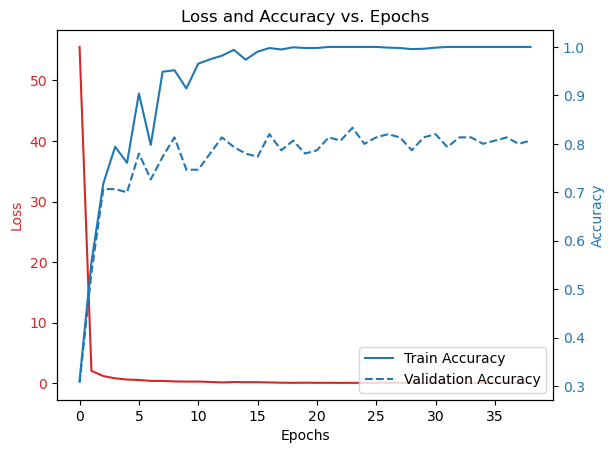

In [ ]:
import matplotlib.pyplot as plt

epochs = range(len(loss_values))

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color=color)
ax1.plot(epochs, loss_values, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(epochs, train_acc_values, color=color, label='Train Accuracy')
ax2.plot(epochs, val_acc_values, color=color, label='Validation Accuracy', linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Loss and Accuracy vs. Epochs')
plt.legend(loc='best')

plt.savefig('./save_files/loss_acc_plot.png', dpi=300)

plt.show()


In [ ]:
import csv

with open('./save_files/loss_acc_values.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Epoch', 'Loss', 'Train Accuracy', 'Validation Accuracy'])
    for i in range(len(loss_values)):
        writer.writerow([i, loss_values[i], train_acc_values[i], val_acc_values[i]])


## Metrics records

In [ ]:
from sklearn import metrics

In [ ]:
mlp.eval()
feats, labels = dataset[val_idxs]
logits = mlp(feats)
_, preds = torch.max(logits, 1)

In [ ]:
np_logits = logits.detach().softmax(dim=1).numpy()

In [ ]:
metrics.precision_recall_fscore_support(labels, preds, average='weighted')

(0.7584351706339528, 0.6862745098039216, 0.7142846639020763, None)

In [ ]:
# AUROC
metrics.roc_auc_score(labels, np_logits, multi_class='ovo')

0.9584567901234567

In [ ]:
aupr_labels = torch.zeros(labels.shape[0], 6)
for i, label in enumerate(labels):
    aupr_labels[i][label] = 1
aupr_labels = aupr_labels.numpy()

In [ ]:
# AUPR
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(6):
    precision[i], recall[i], _ = precision_recall_curve(aupr_labels[:, i],
                                                        np_logits[:, i])
    average_precision[i] = average_precision_score(aupr_labels[:, i], np_logits[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(aupr_labels.ravel(),
    np_logits.ravel())
average_precision["micro"] = average_precision_score(aupr_labels, np_logits,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.4f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.9151


In [ ]:
average_precision["micro"]

0.9150790237341047

# confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
cf_mat = confusion_matrix(labels, preds)

In [ ]:
cf_mat

array([[15,  4,  0,  0,  1,  1],
       [ 5, 23,  2,  0,  0,  0],
       [ 0,  1, 28,  1,  0,  0],
       [ 2,  5,  1,  1,  0,  0],
       [ 0,  0,  0,  0, 29,  1],
       [ 0,  0,  0,  0,  1, 29]])

In [ ]:
pd.DataFrame(cf_mat).to_csv("./save_files/confusion_matrix.csv")

## save MLP embbeddings

In [41]:
def get_x(dataset, cut_point):
    x, _ = dataset[cut_point[0]: cut_point[1]]
    return x
def save_MLP_emb(mlp, dataset, cut_point, name):
    mlp.eval()
    with torch.no_grad():
        x = get_x(dataset, cut_point)
        emb = mlp.retrieve_emb(x)
        torch.save(emb, "./embs/" + name)
        return emb

In [42]:
mlp.load_state_dict(torch.load("./mlp_models/084valacc.pt"))

<All keys matched successfully>

In [43]:
# nas
save_MLP_emb(mlp, dataset, cut_points[0], name="mlp_84_nas.pt")
# lis
save_MLP_emb(mlp, dataset, cut_points[1], name="mlp_84_lis.pt")
# sa
save_MLP_emb(mlp, dataset, cut_points[2], name="mlp_84_sa.pt")
# lissa
save_MLP_emb(mlp, dataset, cut_points[3], name="mlp_84_lissa.pt")
# ir1
save_MLP_emb(mlp, dataset, cut_points[4], name="mlp_84_ir1.pt")
# ir2
save_MLP_emb(mlp, dataset, cut_points[5], name="mlp_84_ir2.pt")

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  7.9829,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ..., 24.0979,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ..., 17.1625,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

# load trained MLP 

In [44]:
del mlp

In [45]:
n_layer = 4
in_dim = emb_nssup_list[0].shape[0]
out_dim = 6
hidden_dim = 128

mlp = MLP(n_layer, in_dim, hidden_dim, out_dim, dropout=0)

In [46]:
# mlp.load_state_dict(torch.load('./mlp_models/084valacc.pt'))

<All keys matched successfully>

In [37]:
# save nassa emb
emb_nassa = torch.stack(emb_nas_sa_list)
emb_nassa.shape

torch.Size([5, 98304])

In [44]:
mlp.eval()
with torch.no_grad():
    emb = mlp.retrieve_emb(emb_nassa)
    torch.save(emb, './embs/mlp_84_nassa.pt')

In [45]:
mlp.eval()
with torch.no_grad():
    emb_sup = torch.stack(emb_sup_list)
    torch.save(mlp.retrieve_emb(emb_sup), './embs/mlp_84_sup.pt')

In [46]:
mlp.eval()
with torch.no_grad():
    emb_nssup = torch.stack(emb_nssup_list)
    torch.save(mlp.retrieve_emb(emb_nssup), './embs/mlp_84_nssup.pt')
    emb_npsup = torch.stack(emb_npsup_list)
    torch.save(mlp.retrieve_emb(emb_npsup), './embs/mlp_84_npsup.pt')
    emb_othersup = torch.stack(emb_othersup_list)
    torch.save(mlp.retrieve_emb(emb_othersup), './embs/mlp_84_othersup.pt')